In [382]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [383]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [384]:
prm_data_path = '../data storage/prm_data_L16_CNN_Nh3.pth'

In [385]:
class CNN2(nn.Module):
    def __init__(self,output_size):
        super(CNN2, self).__init__()
        
        # 畳み込み層
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2, bias=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, bias=True)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=4, stride=4, bias=True)
        
        # 畳み込みの部分
        self.conv = nn.Sequential(
            self.conv1,   
            nn.ReLU(inplace=True),
            self.conv2,   
            nn.ReLU(inplace=True),
            self.conv3,   
            nn.ReLU(inplace=True)
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(3, output_size, bias=True),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x


In [386]:
output_size = 20
model = CNN2(output_size).to(device)

model.load_state_dict(torch.load(prm_data_path), strict=False)
print(model.state_dict())

OrderedDict([('conv1.weight', tensor([[[[ 0.0412, -0.4782],
          [-0.2915,  0.7053]]],


        [[[ 0.2769,  0.0218],
          [-0.0709, -0.3438]]],


        [[[ 0.5176,  0.5105],
          [ 0.5072,  0.5220]]],


        [[[ 0.1568, -0.2470],
          [ 0.3488,  0.2472]]],


        [[[ 0.5812,  0.5612],
          [ 0.5772,  0.4514]]],


        [[[ 0.3902, -0.6706],
          [-0.1842,  0.6214]]],


        [[[ 0.5089, -0.2901],
          [ 0.0173, -0.1720]]],


        [[[ 0.2052, -0.2430],
          [ 0.2484, -0.2173]]],


        [[[-0.1036,  0.1116],
          [ 0.6071, -0.6074]]],


        [[[ 0.5597, -0.2527],
          [-0.2983, -0.1154]]],


        [[[-0.3719, -0.5030],
          [-0.2630, -0.4918]]],


        [[[-0.1697,  0.1734],
          [ 0.3826, -0.2099]]],


        [[[ 0.6714, -0.0278],
          [-0.5815, -0.1547]]],


        [[[-0.1464,  0.1412],
          [ 0.0022,  0.1415]]],


        [[[-0.3255, -0.3545],
          [-0.1800, -0.2783]]],


        [[

In [387]:
fc_weight = model.state_dict()['fc.0.weight']
# NumPy配列に変換
fc_weight_np = fc_weight.cpu().numpy()
# データを転置して
fc_weight_np_square = fc_weight_np.T

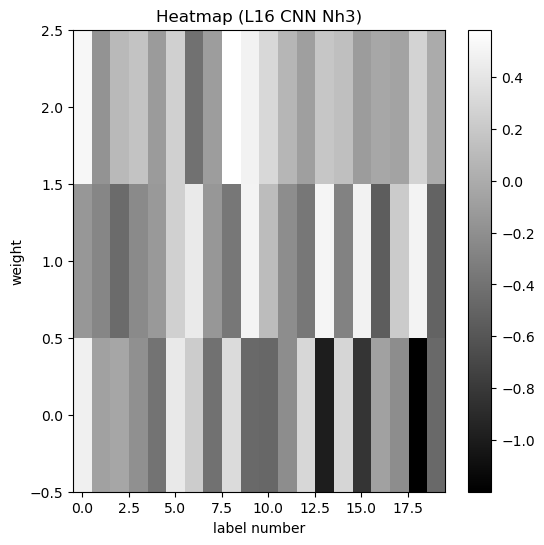

In [388]:
# ヒートマップをプロット（白黒）
plt.figure(figsize=(6, 6))
plt.imshow(fc_weight_np_square, cmap='gray', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.title('Heatmap (L16 CNN Nh3)')


# x軸とy軸に名前を付ける
plt.ylabel('weight')
plt.xlabel('label number')
# 図をファイルとして保存
plt.savefig('../image/L16_CNN_Nh3_wight.png')
plt.show()

In [389]:
fc_weight_np_square_sum = np.sum(fc_weight_np_square, axis=0)

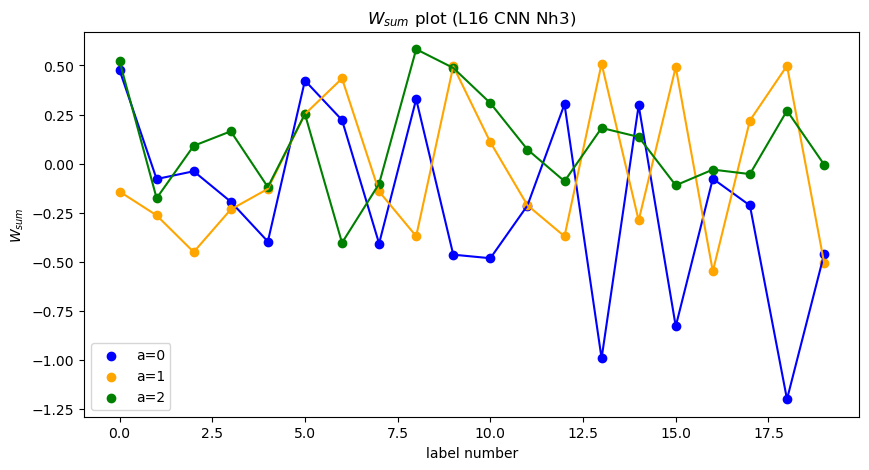

In [390]:
import numpy as np
import matplotlib.pyplot as plt

# データ
x = np.arange(len(fc_weight_np_square[1]))
y0 = fc_weight_np_square[0]
y1 = fc_weight_np_square[1]
y2 = fc_weight_np_square[2]

# プロット
plt.figure(figsize=(10, 5))
plt.scatter(x, y0, color='blue', label='a=0')
plt.scatter(x, y1, color='orange', label='a=1')
plt.scatter(x, y2, color='green', label='a=2')
plt.plot(x, y0, color='blue')
plt.plot(x, y1, color='orange')
plt.plot(x, y2, color='green')
plt.title('$W_{sum}$ plot (L16 CNN Nh3)')
plt.xlabel('label number')
plt.ylabel('$W_{sum}$')

plt.legend()  # 凡例を表示
plt.show()

第1層の出力と磁化の相関図を作成

In [391]:
# 磁化を計算
def magnetization(state):
   return np.mean(state)

In [392]:
import io
import pickle
      
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
# ファイルの相対パスを指定
file_path = '../data storage/Ising_data_L16_v2.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, label_data = loaded_data

In [393]:
# NumPy ndarrayをPyTorch Tensorに変換
spin_data_tensor = [torch.from_numpy(i).unsqueeze(0).type(torch.float32) for i in spin_data]
spin_data_tensor[0].size()

torch.Size([1, 16, 16])

In [394]:
output = [np.squeeze(model(spin_data_tensor[i]).detach().numpy()) for i in range(len(spin_data_tensor))]

In [395]:
a = torch.squeeze(model(spin_data_tensor[1]))
b = [a[i].detach().numpy() for i in range(3)]
b[0]

array(104.28696, dtype=float32)

In [396]:
num_spin_data = len(spin_data)
flat_spin_data = [spin_data[i].flatten() for i in range(num_spin_data)]

In [397]:
fc0_weight = model.state_dict()['fc.0.weight'].numpy()
fc0_bias = model.state_dict()['fc.0.bias'].numpy()

In [398]:
output_data_0 = []
output_data_1 = []
output_data_2 = []
mag_data = []

for i in range(num_spin_data):
    dot_product_0 = output[i][0]
    output_data_0.append(dot_product_0)
    dot_product_1 = output[i][1]
    output_data_1.append(dot_product_1)
    dot_product_2 = output[i][2]
    output_data_2.append(dot_product_2)
    mag = magnetization(flat_spin_data[i])
    mag_data.append(mag)

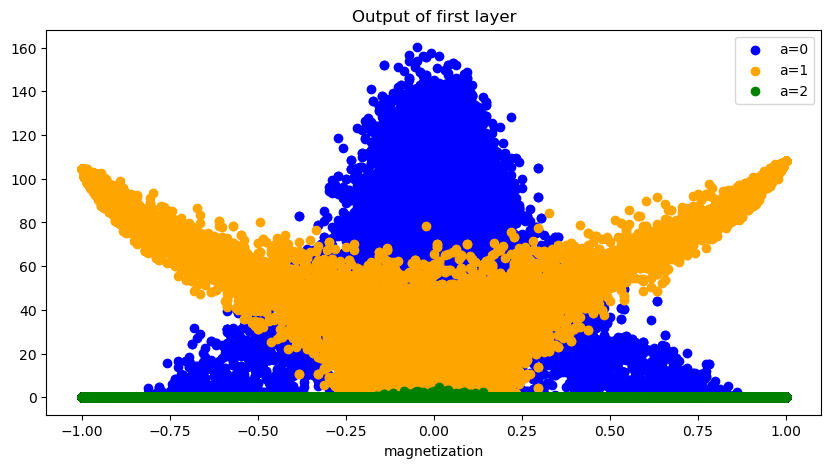

In [406]:
# データ
x = mag_data
y0 = output_data_0
y1 = output_data_1
y2 = output_data_2

# プロット
plt.figure(figsize=(10, 5))
plt.scatter(x, y0, color='blue', label='a=0')
plt.scatter(x, y1, color='orange', label='a=1')
plt.scatter(x, y2, color='green', label='a=2')


plt.title('Output of first layer')
plt.xlabel('magnetization')

# 図をファイルとして保存
plt.savefig('../image/L16_CNN_Nh3_output.png')
plt.legend()  # 凡例を表示
plt.show()

内部エネルギーと磁化の相関図

In [409]:
class LatticeIsing_2D():
    def __init__(self, N, J=1, h=0):
        """
        Attributes:
            N: 格子サイズ
            J: 相互作用
            h: 磁場
        """
        self.N=N
        self.J=J
        self.h=h
    
    def neighor_spin_sum(self, state, x, y):

        center_spin = state[y, x]
        right, left, up, down=x+1, x-1, y+1, y-1

        # 周期境界条件
        if right>=self.N:
            right_spin=state[y, 0]
        else:
            right_spin=state[y, right]
            
        if left<0:
            left=self.N-1
            left_spin=state[y, left]
        else:
            left_spin=state[y, left]
            
        if down<0:
            down=self.N-1
            down_spin=state[down, x]
        else:
            down_spin=state[down, x]
    
        if up>=self.N:
            up_spin=state[0, x]
        else:
            up_spin=state[up, x]
            
        neighor_spin_sum=self.J * center_spin * (right_spin+left_spin+up_spin+down_spin)
        return neighor_spin_sum

    # エネルギーを計算
    def energy(self, state):
        energy=0
        for x in range(self.N):
            for y in range(self.N):
                energy -= self.neighor_spin_sum(state, x, y)/2
        energy -= self.h*np.sum(state)
        energy = energy/256
        return energy
    
    # 磁化を計算
    def magnetization(self, state):
        return np.mean(state)

In [410]:
# イジングモデルのインスタンスを作成
ising_model = LatticeIsing_2D(16)

In [411]:
output_data_0 = []
output_data_1 = []
output_data_2 = []
energy_data = []

for i in range(num_spin_data):
    dot_product_0 = output[i][0]
    output_data_0.append(dot_product_0)
    dot_product_1 = output[i][1]
    output_data_1.append(dot_product_1)
    dot_product_2 = output[i][2]
    output_data_2.append(dot_product_2)
    energy = ising_model.energy(spin_data[i])
    energy_data.append(energy)

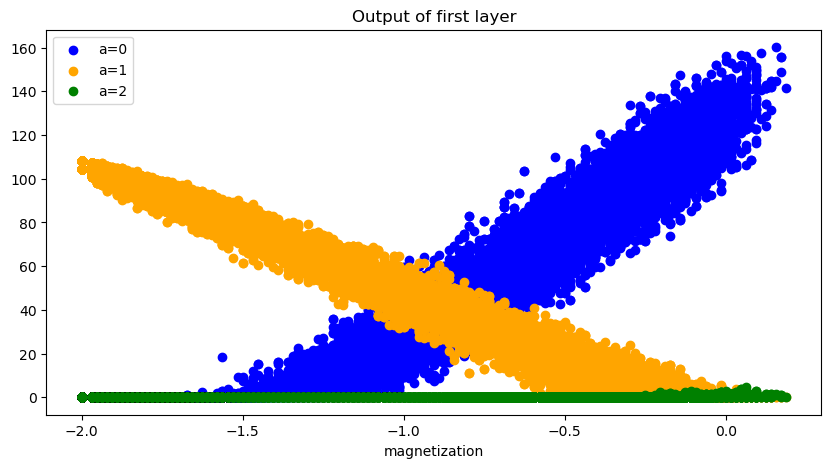

In [412]:
# データ
x = energy_data
y0 = output_data_0
y1 = output_data_1
y2 = output_data_2

# プロット
plt.figure(figsize=(10, 5))
plt.scatter(x, y0, color='blue', label='a=0')
plt.scatter(x, y1, color='orange', label='a=1')
plt.scatter(x, y2, color='green', label='a=2')


plt.title('Output of first layer')
plt.xlabel('magnetization')

# 図をファイルとして保存
plt.savefig('../image/L16_CNN_Nh3_energy.png')
plt.legend()  # 凡例を表示
plt.show()